# eXtreme Gradient Boosting library (XGBoost)

<center>An unfocused introduction by Ivan Nazarov</center>

Import the main toolkit.

In [2]:
import time, os, re, zipfile
import numpy as np, pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Now import some ML stuff

In [4]:
import sklearn as sk, xgboost as xg
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

Mind the seed!!

In [5]:
random_state = np.random.RandomState( seed = 0x0BADC0DE )

Let's begin this introduction with usage examples.

The demonstration uses the dataset, which was originally used in 
[Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge). We load the data directly from ZIP archives.

In [6]:
df_train = pd.read_csv( zipfile.ZipFile( 'train.csv.zip' ).open( 'train.csv' ), index_col = 'id' )
X = np.asanyarray( df_train.drop( 'target', axis = 1 ) )
y = sk.preprocessing.LabelEncoder( ).fit_transform( df_train[ 'target' ] )

As usual do the train-test split.

In [7]:
X_train, X_, y_train, y_ = train_test_split( X, y, test_size = 0.25, random_state = random_state )
X_valid, X_test, y_valid, y_test = train_test_split( X_, y_, test_size = 0.5, random_state = random_state )

## scikit-learn interface

Use scikit-learn compatible interface of XGBoost.

In [9]:
clf_ = xg.XGBClassifier( n_estimators = 50,
                         gamma = 1.0,
                         max_depth = 1000,
                         objective = "multi:softmax",
                         nthread = -1,
                         silent = False )

Fit the a gradient boosted tree ensemble.

In [10]:
clf_.fit( X_train, y_train, eval_set = [ ( X_valid, y_valid ), ], verbose = True )

[0]	validation_0-merror:0.232191
[1]	validation_0-merror:0.215902
[2]	validation_0-merror:0.205430
[3]	validation_0-merror:0.202715
[4]	validation_0-merror:0.200776
[5]	validation_0-merror:0.198966
[6]	validation_0-merror:0.197544
[7]	validation_0-merror:0.194958
[8]	validation_0-merror:0.193794
[9]	validation_0-merror:0.192760
[10]	validation_0-merror:0.191597
[11]	validation_0-merror:0.190692
[12]	validation_0-merror:0.189270
[13]	validation_0-merror:0.188235
[14]	validation_0-merror:0.186813
[15]	validation_0-merror:0.186555
[16]	validation_0-merror:0.186037
[17]	validation_0-merror:0.184874
[18]	validation_0-merror:0.183969
[19]	validation_0-merror:0.182547
[20]	validation_0-merror:0.181642
[21]	validation_0-merror:0.182030
[22]	validation_0-merror:0.180995
[23]	validation_0-merror:0.180220
[24]	validation_0-merror:0.180091
[25]	validation_0-merror:0.181513
[26]	validation_0-merror:0.181771
[27]	validation_0-merror:0.180478
[28]	validation_0-merror:0.179573
[29]	validation_0-merror

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.0, learning_rate=0.1, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=50, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1)

Now let's validate.

In [11]:
y_predict = clf_.predict( X_test )
y_score = clf_.predict_proba( X_test )

Let's check out the confusuion matrix

In [12]:
pd.DataFrame( sk.metrics.confusion_matrix( y_test, y_predict ), index = clf_.classes_, columns = clf_.classes_ )

,0,1,2,3,4,5,6,7,8
0,111,8,3,0,0,28,12,43,52
1,2,1771,249,22,2,2,18,3,3
2,0,390,537,25,0,6,16,4,2
3,0,81,57,174,4,9,2,0,1
4,0,3,1,0,299,0,0,1,1
5,4,12,2,5,3,1633,17,31,26
6,7,34,30,3,0,18,212,18,5
7,10,6,5,0,0,32,4,1028,17
8,19,8,2,2,1,24,2,27,546


Let's plot one-vs-all ROC-AUC curves

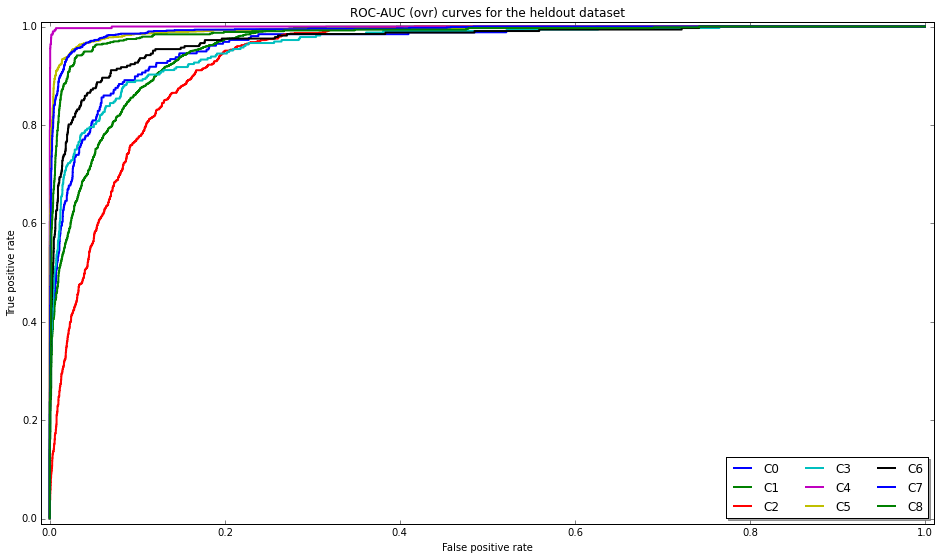

In [13]:
fig = plt.figure( figsize = ( 16, 9 ) )
axis = fig.add_subplot( 111 )
axis.set_title( 'ROC-AUC (ovr) curves for the heldout dataset' )
axis.set_xlabel( "False positive rate" ) ; axis.set_ylabel( "True positive rate" )
axis.set_ylim( -0.01, 1.01 ) ; axis.set_xlim( -0.01, 1.01 )
for cls_ in clf_.classes_ :
    fpr, tpr, _ = sk.metrics.roc_curve( y_test, y_score[:, cls_], pos_label = cls_ )
    axis.plot( fpr, tpr, lw = 2, zorder = cls_, label = "C%d" % ( cls_, ) )
axis.legend( loc = 'lower right', shadow = True, ncol = 3 )

## alternative interface

Internally XGBoost relies heavily on a custom dataset format **DMatrix**. It is ...
The interface, which is exposed into python has three capabilities:
- load datasets in libSVM compatible format;
- load SciPy's sparse matrices;
- load Numpy's ndarrays.

Let's load the train dataset using numpy interface :
- **data** : the matrix of features $X$;
- **label** : the observation labels $y$ (could be categorical or numeric);
- **missing** : a vector of values that encode missing observations;
- **feature_names** : the columns names of $X$;
- **feature_types** : defines the python types of each column of $X$, in case of heterogeneous data;
- **weight** : the vector of nonnegative weights of each observation in the dataset.

In [20]:
train_dmat = xg.DMatrix( data = X_train,
                         label = y_train,
                         feature_names = None,
                         feature_types = None )
test_dmat = xg.DMatrix( data = X_test, label = y_test )

**DMatrix** exports several useful methods:
- **num_col()** : returns the number of columns;
- **num_row()** : gets the number of items;
- **save_binary( fname )** : saves the **DMatrix** object into a specified file.

For a more detailed list, it is useful to have a look at [the official manual](https://xgboost.readthedocs.org/en/latest/python/python_api.html)

Having dafined the datasets, it is the right time to initialize the booster. To this end one uses **xgboost.Learner** class. Among other parameters, its instance is initialized with a dictionary of parameters, which allows for a more flexible booster initialization.

In [26]:
xgb_params = {
    'bst:max_depth':2,
    'bst:eta':1,
    'silent':1,
    'objective':'multi:softmax',
    'num_class': 9,
    'nthread': 2, 
    'eval_metric' : 'auc'
}

The **xgboost.train** class initalizes an appropriate booster, and then fits it on the provided train dataset. Besides the booster parameters and the train **DMatrix** , the class initializer accepts:
- **num_boost_round** : and interger number of boosting iterations which is the number of trees in the final ensemble;
- **evals** : a list of **DMatrix** validation datasets to be evaluated during training;
- **obj** : a custom objective function;
- **feval** : a custom evaluation function;
- **early_stopping_rounds** : Activates early stopping, which checks every **early_stopping_rounds** round(s) if the validation error has decreased in order to continue training;
- **maximize** : a flag, which determines if the objective (feval) should be maximized;
- **learning_rates** : a schedule for learning rates for each boosting round or a function that calculates $\eta$, for the current round;
- **xgb_model** : an XGB model (booster or file), the training of which is to be continued.

In [27]:
xgbooster_ = xg.train( params = xgb_params,
                       dtrain = train_dmat, 
                       num_boost_round = 10,
                       evals = (),
                       obj = None,
                       feval = None,
                       maximize = False,
                       early_stopping_rounds = None,
                       evals_result = None,
                       verbose_eval = True,
                       learning_rates = None,
                       xgb_model = None )

The method **xgboost.booster.update** performs one iteration of gradinet boosting:
- **dtrain** : **DMatrix** of train dataset;
- **iteration** : the current iteration number;
- **fobj** : a custom objective function touse for this update.

The method **xboost.booster.boost** performs one iteration of boosting on the custom gradient statistics:
- **dtrain** : the **DMatrix** dataset to operate on;
- **grad**, **hess** : pair of lists of loss gradients and hessians, respectively, evaluated at each datapoint in **dtrain**.

The method **xgboost.booster.predict** returns either the learned value, or the index of the target leaf. The parameters are :
- **data** : a **DMatrix** object storing the input;
- **output_margin** : a flag, determining, if raw untransformed margin values should be returned;
- **ntree_limit** : limit the number of trees used for predicting (defaults to 0, which use all trees);
- **pred_leaf** : determined wether the output should be a matrix of $(n, K)$ of predicted leaf indices, where $K$ is the number of trees in the ensemble.

The returned result is a **numpy ndarray**.

In [28]:
y_predict = xgbooster_.predict( test_dmat )
y_score = xgbooster_.predict( test_dmat, output_margin = True )

Besides these methods **xgboost.booster** exports:
**load_model**( fname ) and **save_model**( fname ).

Let's check out the confusuion matrix

In [29]:
pd.DataFrame( sk.metrics.confusion_matrix( y_test, y_predict ), index = clf_.classes_, columns = clf_.classes_ )

,0,1,2,3,4,5,6,7,8
0,88,16,7,1,1,28,12,42,62
1,1,1714,289,33,4,6,11,5,9
2,0,552,366,19,2,4,21,7,9
3,1,146,54,98,4,17,4,0,4
4,0,12,1,0,292,0,0,0,0
5,8,28,10,6,1,1591,16,45,28
6,5,49,39,5,0,23,179,24,3
7,22,20,13,1,0,38,14,954,40
8,15,34,8,1,3,32,2,55,481


Let's plot one-vs-all ROC-AUC curves

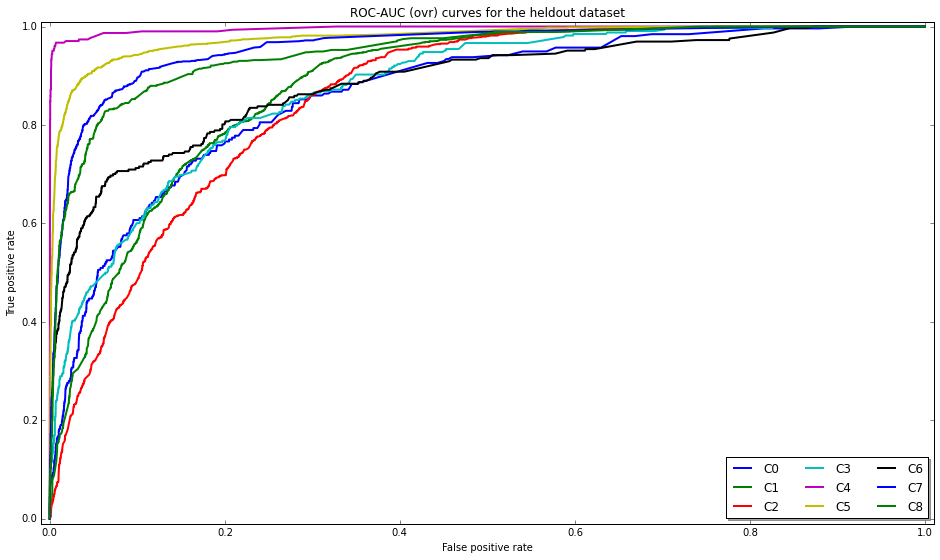

In [30]:
fig = plt.figure( figsize = ( 16, 9 ) )
axis = fig.add_subplot( 111 )
axis.set_title( 'ROC-AUC (ovr) curves for the heldout dataset' )
axis.set_xlabel( "False positive rate" ) ; axis.set_ylabel( "True positive rate" )
axis.set_ylim( -0.01, 1.01 ) ; axis.set_xlim( -0.01, 1.01 )
for cls_ in clf_.classes_ :
    fpr, tpr, _ = sk.metrics.roc_curve( y_test, y_score[:, cls_], pos_label = cls_ )
    axis.plot( fpr, tpr, lw = 2, zorder = cls_, label = "C%d" % ( cls_, ) )
axis.legend( loc = 'lower right', shadow = True, ncol = 3 )

## Theoretical background 

Consider some dataset $(x_i, y_i)_{i=1}^n \in X\times Y$, where $X$ is the feature space and $Y$ is the space of target values. Let $\mathtt{Obj}(\theta)$ be the objective function, which we wish to minimize by learning a model (or a set of parameters). The objective has two components, which depend on the paramter set $\theta$ :
$$\mathtt{Obj}(\theta) = L(\theta) + \Omega(\theta)\,. $$
Here $L$ is the trainig loss function, which reflects the overall quaility and fittness of the learned model, and $\Omega$ is the regularization term, which controls overfitting by penalizing the model's complexity.
The working assumption here is theat the more complex the model the more likely it is to fail to generalize and overfit.

Let $\mathcal{M}$ be the set of base models for the ensemble, for instance, CART tree. An learner tries to find a pool of $K$ models $(f_k)_{k=1}^K \in \mathcal{M}$, which, when aggregated into an ensemble
$$ \hat{y}(x) = \sum_{k=1}^K f_k(x)\,, $$
minimize the objective function
$$\mathtt{Obj} = \sum_{i=1}^n l( y_i, \hat{y}(x_i) ) + \sum_{k=1}^K \Omega(f_k)\,,$$
with $l(y, \hat{y})$ being the loss, and $\Omega(\cdot)$ -- the complexity regularizer.

In a general nonlinear and non-convex case solving the follwing optimiation problem is hard:
$$ \sum_{i=1}^n l( y_i, \hat{y}_i ) + \sum_{k=1}^K \Omega(f_k)
    \rightarrow \mathop{\mathtt{min}}_{f_k\in\mathcal{M} } \,,$$
with $\hat{y}_i = \sum_{k=1}^K f_k(x_i)$. No general technique for solving it is known, other than applying
a clever variant of exhaustive search. Furthermore minimizing the objective to the extreme might be undesirable, as the data might be subject to random noise and other impurities.

If optimizing the objective function (either the original or modified in some way) over one base model (function) is tractable and can be dome efficiently, then one could apply greedy search method, the search space of which is much narrower.

### FSAM

**F**orward **S**tagewise **A**dditive **M**odelling is a general greedy approach to modelling additive enesembles.
The basic idea of this approach is to construct a suboptimal model incrementally in a greedy fashion. For the objective function $\mathtt{Obj}$ the approach is outlined below:
1. set $F_0 = 0$;
2. for $k = 1,\ldots, K$ do:
    1. using some efficient method find at least a good approximation to the following:
    $$f_k \leftarrow \mathop{\mathtt{argmin}}\limits_{f\in \mathcal{M}}
                                \sum_{i=1}^n l( y_i, F_{k-1}(x_i) + f(x_i) ) + \Omega(f) \,,$$
       where the complexity penalty $\Omega(F_{k-1}) = \sum_{j=1}^{k-1} \Omega(f_j) $ is omitted, since it does not depend on $f_k$;
    2. set $ F_k = F_{k-1} + f_k$;
3. Return $F_K$.

### Gradient boosting

The gradinet boosting algorithm, in its simplest form is outlined below.

1. set $F_0 = 0$;
2. for $k = 1,\ldots, K$ do:
    1. compute the direction of the greatest descent at the the datapoints $(x_i, \hat{y}_i)_{i=1}^n$
    with $\hat{y}_i = F_{k-1}(x_i)$:
        $$ g^{k-1}_i = -
            \biggl.
                \frac{\partial}{\partial \hat{y}_i} L\bigl( (y_i)_{i=1}^n, (\hat{y}_i)_{i=1}^n \bigr) 
            \biggr\rvert_{\hat{y}_i = F_{k-1}(x_i)}\,, $$
    where $L\bigl( (y_i)_{i=1}^n, (\hat{y}_i)_{i=1}^n \bigr) = \sum_{i=1}^n l( y_i, \hat{y}_i )$;
    2. attempt to generalize the loss gradient by fitting a regression tree
    to $(x_i, g^{k-1}_i)_{i=1}^n$;
    3. for the resulting partition structure $(R_j)_{j=1}^J$ compute
        $$w_j^* \leftarrow \mathop{\mathtt{argmin}}\limits_{w\in \mathbb{R}}
                        \sum_{i\,:\,x_i\in R_j} l( y_i, \hat{y}_i + w ) + \Omega(w)\,,$$
       where $\Omega(w)$ is the regularizer term for weight $w$;
    4. set $f_k = \sum_{j=1}^J w_j^* 1_{R_j}$;
    5. update $ F_k \leftarrow F_{k-1} + \eta f_k$;
3. Return $F_K$.

### General objectives

In order to permit the use of arbitrary convex loss functions and still achieve high preformance during learning, the author of XGBoost, implemented a clever trick: the minimization with respect to the increment $f(\cdot)$ is performed on the second order Taylor series approximation of the loss $l$ at $(x_i, y_i)$ and $F(\cdot)$. In particular the minimization over $f(\cdot)$ is done on
$$ q_{y, x} = l( y, F(x) ) + \frac{\partial l}{\partial \hat{y}}\bigg\vert_{(y,F(x))}\!\! f(x)
                          + \frac{1}{2} \frac{\partial^2 l}{\partial \hat{y}^2}\bigg\vert_{(y,F(x))}\! f(x)^2  \,, $$
rather than $l( y, F(x) + f(x) )$.

Since $\Omega(F_{k-1})$ and $l( y_i, F_{k-1}(x_i) )$ are unaffected by the choice of $f\in\mathcal{M}$ at iteration $k$, the greedy step can be reduced to:
$$f_k \leftarrow \mathop{\mathtt{argmin}}\limits_{f\in \mathcal{M}}
                                \sum_{i=1}^n g^{k-1}_i f(x_i) + \frac{1}{2} h^{k-1}_i f(x_i)^2 + \Omega(f)\,,$$
where
$g^{k-1}_i = \frac{\partial l(y, \hat{y})}{\partial \hat{y}}$ and $h^{k-1}_i = \frac{\partial^2 l(y, \hat{y})}{\partial \hat{y}^2}$ evaluated at $y=y_i$ and $\hat{y}=F_{k-1}(x_i)$.

it turned out to be efficient and no less it was deemed better to approximate

### Model class

XGBoost library implements two base models, $f:X\to \mathbb{R}$: linear approximator and nonlinear tree-like model. A linear base model is of the form 
$$ f(x) = \beta_0 + x\beta \,, $$
where $\beta_0\in \mathbb{R}$ is the intercept and $\beta\in \mathbb{R}^{d\times 1}$ is the vector of coefficients.

Regression tree models are a subcalss of piecewise-constant models:
$$ f(x) = \sum_{j=1}^J w_j 1_{R_j}(x)\,, $$
where $R = (R_j)_{j=1}^J \subseteq X$ is a partition of the domain $X$ into non-overlapping regions, and $w_j$ is the level of $f$ for all $x$, which fall within leaf $j$, $x\in R_j$.
Since $R$ is partition, for any $x\in X$ there is a unique $j(x)=1,\ldots,J$ such that $x\in R_{j(x)}$.
Therefore in a more compact representation: for any $x\in X$
$$ f(x) = w_{j(x)} \,.$$

The regression tree model $f$ is directly used to predict the target value $y\in \mathbb{R}$ given some $x\in X$, embedded in $\mathbb{R}^p$.

The specific feature of tree models is that the partition $R$ is constructed in a recursive manner until some criteria for tree's structural score are met, and the final tree structure reflects the recursion tree.

It important to note, that XGBoost implements binary trees, which does not restrict the model in any way. However this add the need for an extra preprocessing step for categorical features. Specifically the binary structure requires that such features be one-hot encoded, which is likely to use excessive volumes of memory, especially when the set of possible categories is of the order of thousands.

### Optimizing the objective

XGBoost uses criteria derived from the objective function that permit automatic tree-pruning. Consider some tree $f$ with structure
$$ f = \sum_{j=1}^J w_j 1_{R_j} \,,$$
where $(R_j)_{j=1}^J\subseteq X$ is its partition and $w\in\mathbb{R}^J$ -- leaf predicted values. For this tree the complexity regularization is
$$ \Omega(f) = \gamma J + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| \,. $$
As one can see both excessively large leaf values and tree depths are penalized.

The **structural score** of an XGBoost regression tree is the minimal value of the objective function for a fixed partition structure $R = (R_j)_{j=1}^J$:
$$ \mathtt{Obj}^*(R)
        = \min_{w_j} \mathtt{Obj}(R, w)
        = \min_{w_j} \sum_{i=1}^n \bigl( g^{k-1}_i w_{j(x_i)} + \frac{1}{2} h^{k-1}_i w_{j(x_i)}^2 \bigr)
                     + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| + \gamma J
        \,. $$
This is not an intermediate value of the objective function, but rather its difference against $\sum_{i=1}^n l( y_i, F_{k-1}(x_i) )$.

Using the map $x\mapsto j(x)$, which gives the unique leaf index $j=1,\ldots,J$ such that $x\in R_j$, the objective function can be transformed into
\begin{align*}
\mathtt{Obj}(R, w) &= \sum_{i=1}^n \bigl( g^{k-1}_i w_{j(x_i)} + \frac{1}{2} h^{k-1}_i w_{j(x_i)}^2 \bigr)
                  + \frac{\lambda}{2} \sum_{j=1}^J w_j^2 + \alpha \sum_{j=1}^J \bigl|w_j\bigr| + \gamma J \\
             &= \sum_{j=1}^J \bigl( w_j G_{k-1}(R_j) + \frac{1}{2} \bigl( H_{k-1}(R_j) + \lambda \bigr) w_j^2
                  + \alpha \bigl|w_j\bigr| + \gamma \bigr) \,,
\end{align*}
where for any $P\subseteq X$, the values $G_{k-1}(P) = \sum_{i\,:\,x_i\in P} g^{k-1}_i$ and $H_{k-1}(P) = \sum_{i\,:\,x_i\in P} h^{k-1}_i$ are called the **first** and the **second** order gradient scores respectively.
When $P = R_j$ these are the $j$-th leaf gradinet statistics, which depend only on the ensemble $F_{k-1}$ and 
are constant relative to the increment $f$.

It is worth noting, that since there are no cross interactions between scores $w_j$ for different leaves, this minimization problem equivalently reduces to $J$ univariate optimization problems:
$$ w_j G_{k-1}(R_j) + \frac{1}{2} \bigl( H_{k-1}(R_j) + \lambda \bigr) w_j^2
                    + \alpha \bigl|w_j\bigr| + \gamma \to \min_{w_j}\,,$$
for $j=1,\ldots, J$. Let's assume that $H_{k-1}(R_j) + \lambda > 0$, since otherwise this problem has no solution.

The optimal leaf value $w_j^*$ in the general case is given by
$$ w^*_j = - \frac{1}{H_{k-1}(R_j) + \lambda}\begin{cases}
G_{k-1}(R_j) + \alpha & \text{ if } G_{k-1}(R_j) \leq -\alpha\\
0&\text{ if } G_{k-1}(R_j) \in [-\alpha, \alpha]\\
G_{k-1}(R_j) - \alpha & \text{ if } G_{k-1}(R_j) \geq \alpha
\end{cases} \,, $$
see appendix for a solution.

### Tree construction process

Trees in XGBoost employ a greedy algorithm for recursive tree construction, outlined below:
 1. every region $R_j$ in the partition $R$ is probed for the optimal binary split
    $R_j\to R_{j_1}\!\|R_{j_2}$ according to the structural gain score
    $$ \mathtt{Gain}\bigl( R_j\to R_{j_1}\!\| R_{j_2} \bigr) = \mathtt{Obj}^*( R ) - \mathtt{Obj}^*( R' ) \,, $$
    where the partition $R'$ is constructed from $R$ by splitting $R_j\to R_{j_1}\|R_{j_2}$;
 2. the region $R_j$ with the highest gain from the optimal split is split into $R_{j_1}$ and $R_{j_2}$;
 3. the tree growth process continues until no more splits are possible.
 
 The first step in sthe most computatuionally intensive, since it requires $O( J d n\log n )$ operations.

For simplicity, let's consider the case when $\alpha = 0$, $L^2$ regularization. In this case the following weights give optimal leaf scores
$$ w^*_j = -\frac{G_{k-1}(R_j)}{H_{k-1}(R_j) + \lambda}\,.$$
The strucutral score becomes
$$ \mathtt{Obj}^*(R) = \gamma J - \frac{1}{2}\sum_{j=1}^J \frac{G_{k-1}^2(R_j)}{H_{k-1}(R_j) + \lambda} \,. $$

Any split $R_j \rightarrow R_{j_1}\!\| R_{j_2}$ yields the following gain:
$$ \mathtt{Gain} = \frac{1}{2}\Biggl(
                          \frac{G_{k-1}^2(R_{j_1})}{H_{k-1}(R_{j_1}) + \lambda}
                        + \frac{G_{k-1}^2(R_{j_2})}{H_{k-1}(R_{j_2}) + \lambda}
                        - \frac{G_{k-1}^2(R_j)}{ H_{k-1}(R_j) + \lambda}
                   \Biggr) - \gamma\,.$$
Note that $G_{k-1}(\cdot)$ and $H_{k-1}(\cdot)$ are additive by construction:
$$G_{k-1}(R_j) = G_{k-1}(R_{j_1}) + G_{k-1}(R_{j_2}) \,,$$
and
$$H_{k-1}(R_j) = H_{k-1}(R_{j_1}) + H_{k-1}(R_{j_2}) \,.$$

## Internal Pipeline

The processing pipeline for one iteration of gradient boosting is as follows:
1. invoke **BoostLearner**->UpdateOneIter() (**learner-inl.hpp**)
    1. **IGradBooster**->Predict()
    2. **IObjFunction**->GetGradient() (**objective-inl.hpp**)
    3. **IGradBooster**->DoBoost()
2. repeat the specified **number of rounds**. 

XGBoost implements two types of boosters: the **linear** and **tree** bnosters:
* the linear booster (__"gblinear"__) constructs ensembles of regularized linear models;
* the tree bostrer (__"gbtree"__) learns an ensemble approximator from piecewise-constant, tree-based base models.

### gbtree booster

The **gbtree** booster ( **GBTree : public IGradBooster**) is located in **gbtree-inl.hpp**, and is responsible for constructing one or more regression trees for the provided fixed gradient statistics $(g^{k-1}_i, h^{k-1}_i)_{i=1}^n$ (**const std::vector &lt;bst_gpair &gt; &amp;**), which are kept intact during this booster's run.

The main procedure, that does all the work is **GBTree**->DoBoost(), which in turn invokes **GBTree**->BoostNewTrees(). The latter workhorse grows the required number of trees, determined by the parameter **num_parallel_tree**. For **regular tree boosting** this parameter is set to $1$, but for a **boosted random forest** its value determines the size of the forest.

Each regression tree in **GBTree**->BoostNewTrees() is constructed via sequential application of so called **updaters** among which the most frequqntly used are 
- grow_colmaker **ColMaker : public IUpdater** (**updater_colmaker-inl.hpp**);
- prune **TreePruner : public IUpdater** (**updater_prune-inl.hpp**).

The **ColMaker** updater does not take into consideration the tree size cost, and thus constructs the deepest possible binary regression tree. The **ColMaker**->Update() method performs the following steps:
1. shares the relevant gradient data among all computational threads (**ColMaker**->InitData());
2. initializes the queue of leaves and propagates the necessary statistics through the tree (**ColMaker**->InitNewNode());
3. while there are leaves in queue do:
    1. performs the **first** step of the algorithm outlined above in parallel computational threads (**ColMaker**->FindSplit());
    2. determines in parallel the new parent regions for each $(x_i)_{i=1}^n$ in the dataset (**ColMaker**->ResetPosition());
    3. updates the queue and propagates the necessary statistics through the tree (**ColMaker**->InitNewNode());(

The **TreePruner** updater is much simpler than the **ColMaker**. Its method **TreePruner**->Update() recursively tries to do cost-complexity pruning with respect to the split gains computed earlier. The pruning rule is whether the structural gain exceed the threshold $\gamma$. In contrast to tree growth, pruning is not done in parallel.

#### Parameters

The tree based booster has much richer settings, though some coincide with the linear booster:
- **eta**, **learning_rate** ($\eta$) -- step size shirinkage factor;
- **gamma** ($\gamma$) -- the complexity cost parameter, imposes minimal structural score gain for splitting a leaf of the currnt tree;
- **max_depth** -- this parameters limits the size of the tree, by setting a hard bound on the number of tree layers;
- **min_child_weight** -- the minimal values of the hessian statistic of a leaf to be considered a candidate for splitting;
- **max_delta_step** -- clips the absolute value of each leaf's score, thereby making the tree growth step more conservative;
- **lambda** ($\lambda$) -- the weight of the $L^2$ regularization term;
- **alpha** ($\alpha$) -- the importance of the $L^1$ regularizer;
- **subsample** -- the share of the training data to use for growing a tree;
- **colsample** -- subsample ratio of features when constructing each tree.

By default, the booster uses all features and all train dataset to construct each new tree. Other important default values are:
* **max_depth** is set to 6 (in C code at least);
* **gamma** is also set to zero, which means that the number of leaves in the tree is not penalized.

### gblinear booster

The **gblinear** booster (** GBLinear : public IGradBooster **) is defined in **gblinear-inl.hpp**. It constructs boosted linear models for the given gradient statistics $(g^{k-1}_i, h^{k-1}_i)_{i=1}^n$ (**std::vector &lt;bst_gpair &gt; &amp;**), which though with no **const** qualifier, are also unchanged during the run.

Unlike **gbtree** this booster does not rely on any auxiliary **updaters**. The main procedure, that does all the work is **GBLinear**->DoBoost(), which estimates a linear approximation.

#### Parameters

The linear booster requires only three parameters:
- **eta**, **learning_rate** ($\eta$) -- step size shirinkage factor;
- **lambda** ($\lambda$) -- the weight of the $L^2$ regularization term in the objective function;
- **alpha** ($\alpha$) -- the importance of the $L^1$ regularizer in the objective function;
- **lambda_bias** ($\lambda_{\texttt{bias}}$) -- a weight of $L^2$ regularization of the intercept term.
    
The reglarization term of the objectve function for a linear base model $f(x) = \beta_0 + x\beta$ is
$$ \Omega(f) = \frac{\lambda}{2} \| \beta \|_2^2 + \alpha \| \beta \|_1 + \lambda_{\texttt{bias}} |\beta_0|^2 \,.$$

Note, that unlike **scikit-learn**, in **XGBoost** these parameters default ot $0$ -- no regularization.

### Parameter effects

When we allow the model to get more complicated (e.g. more depth), the model has better ability to fit the training data, resulting in a less biased model. However, such complicated model requires more data to fit.

The first way is to directly control model complexity
	* max_depth, min_child_weight and gamma

The second way is to add randomness to make training robust to noise
	* subsample, colsample_bytree
	* reduce stepsize eta, but needs to remember to increase num_round when you do so.


dataset is extremely imbalanced. This can affect the training of xgboost model, and there are two ways to improve it.
the ranking order (AUC) of your prediction: Balance the positive and negative weights, via scale_pos_weight

If you care about predicting the right probability: In such a case, set parameter max_delta_step



## References

* T. Hastie, R. Tibshirani, J. Friedman, The Elements of Statistical Learning, Springer New York Inc., 2009.
* Tianqi Chen, [Introduction to Boosted Trees](https://xgboost.readthedocs.org/en/latest/model.html)

## Appendix

The problem
$$ w G + \frac{1}{2}( H+\lambda ) w^2 + \alpha \bigl|w\bigr| \to \min_w\,,$$
can be solved by the following substitution: $w = w_+ - w_-$, with $w_- \cdot w_+ = 0$ and $w_-, w_+\geq 0$.
Notice that it is assumed that $H+\lambda > 0$.

Indeed, the Lagrangian is 

$$ L = (  w_+ G + \frac{1}{2}( H+\lambda ) w_+^2 + \alpha w_+ - \mu_+w_+ )
     + (- w_- G + \frac{1}{2}( H+\lambda ) w_-^2 + \alpha w_- - \mu_-w_- )
     - \mu w_-w_+\,, $$
whence the KKT conditions are
* **Primal**: $w_-\cdot w_+ = 0$, $w_+,w_-\geq 0$;
* **Dual**: $\mu_-, \mu_+ \geq 0$;
* **Complementary slackness**: $\mu_-w_- = 0$ and $\mu_+ w_+ = 0$;
* **First-order**: 
    $$ G + ( H+\lambda ) w_+ + \alpha - \mu_+ - \mu w_- = 0 \,, $$ 
    and
    $$ -G + ( H+\lambda ) w_- + \alpha - \mu_- - \mu w_+ = 0 \,. $$

Multiplying the FOC by $w_+$ and $w_-$ respectively, and using $w_-\cdot w_+ = 0$, yields
$$ \bigl(  G + ( H+\lambda ) w_+ + \alpha - \mu_+ \bigr) w_+ = 0 \,, $$ 
and
$$ \bigl( -G + ( H+\lambda ) w_- + \alpha - \mu_- \bigr) w_- = 0 \,. $$

A pair $w_- = w_+ = 0$ is feasible and satisfied FOC, while a pair $w_+ > 0$ and $w_- > 0$ is infeasible.

Now, if $w_->0$ and $w_+=0$, then $\mu_-=0$ and
$$ -G + ( H + \lambda ) w_- + \alpha = 0 \,,$$
which yields
$$ w_- = -\frac{\alpha - G}{ H + \lambda } \,,$$
whence $ \alpha < G $.

Conversely, if $w_+>0$ and $w_-=0$, then $\mu_+=0$, and 
$$ G + ( H+\lambda ) w_+ + \alpha = 0 \,. $$
This implies that
$$ w_+ = -\frac{\alpha + G}{H+\lambda}\,, $$
which requires that $G<-\alpha$.

However, since the inequalitites $G<-\alpha$ and $G>\alpha$ are incompatible:
* $G<-\alpha$ implies $w_+\geq0$ and $w_-=0$ with $w_+ = (H+\lambda)^{-1}\max(-G -\alpha;0)$;
* $G>\alpha$ implies $w_-\geq0$ and $w_+=0$ with $w_- = (H+\lambda)^{-1}\max( G -\alpha;0)$;
* $G\in[-\alpha, \alpha]$ leads to $w_+ = w_- = 0$.

Therefore the optimal $w$ in this problem is given by
$$ w = - (H+\lambda)^{-1}\bigl( \min(G + \alpha;0) + \max( G - \alpha;0) \bigr) \,. $$